In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

from sklearn.preprocessing import MinMaxScaler

torch.manual_seed(2)
np.random.seed(2)

In [2]:
file_path = 'Project/measures_v2.csv'

df = pd.read_csv(file_path)

In [3]:
df.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


In [4]:
col_list = df.columns.tolist()
profile_id = ['profile_id']
target_list = ['pm', 'torque', 'stator_yoke', 'stator_tooth', 'stator_winding']
feature_list = [col for col in col_list if col not in target_list and col not in profile_id]

In [5]:
df['profile_id'] = df.profile_id.astype('category')
df.profile_id.unique()

[17, 5, 12, 32, 21, ..., 60, 46, 58, 78, 71]
Length: 69
Categories (69, int64): [2, 3, 4, 5, ..., 78, 79, 80, 81]

In [6]:
df_dict = {}
for id_ in df.profile_id.unique():
    df_dict[id_] = df[df['profile_id']==id_].reset_index(drop = True)

In [7]:
def build_sequences(features_df, target_df, sequence_length = 10):
    """Builds sequences from data and converts them into pytorch tensors
        sequence_length - represents the number of samples to be considered in a sequence
    """
    data_ = []
    target_ = []
    
    for i in range(int(features_df.shape[0]/sequence_length)):
        
        data = torch.from_numpy(features_df.iloc[i:i+sequence_length].values)
        target = torch.from_numpy(target_df.iloc[i+sequence_length+1].values)
        
        data_.append(data)
        target_.append(target)
        
    data = torch.stack(data_)
    target = torch.stack(target_)
    
    return data, target

In [8]:
specific_indices = [20, 6, 65, 18, 66, 13, 27, 4, 58, 56, 53, 79, 44, 70, 62, 30, 80, 74, 68, 36, 76, 48, 12, 29, 32, 16, 9, 2, 3, 8, 14, 15, 81, 21, 45, 42, 73, 41, 63, 26, 17, 31, 69]

In [9]:
prof_ids = list(df_dict.keys())
df_dict.keys()

dict_keys([17, 5, 12, 32, 21, 2, 4, 7, 19, 3, 9, 23, 27, 26, 11, 6, 10, 13, 31, 18, 30, 29, 8, 24, 20, 15, 14, 16, 36, 74, 75, 41, 68, 50, 53, 49, 81, 80, 59, 54, 57, 70, 51, 55, 45, 69, 61, 76, 56, 64, 72, 73, 62, 65, 63, 43, 47, 66, 42, 48, 67, 44, 79, 52, 60, 46, 58, 78, 71])

In [10]:
prof_id = 6

curr_df = df_dict[prof_id]

curr_df = curr_df.drop('profile_id', axis = 1)
columns = curr_df.columns.tolist()

In [11]:
scaler = MinMaxScaler()

curr_df = pd.DataFrame(scaler.fit_transform(curr_df), columns= columns)
curr_df.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque
0,0.173390,0.064550,0.000711,0.495541,0.000105,0.000066,0.957416,0.635014,0.000142,0.000600,0.422350,0.605967
1,0.174028,0.064815,0.000582,0.495157,0.000087,0.000064,0.955582,0.640728,0.000089,0.000826,0.424296,0.610011
2,0.174470,0.064977,0.000427,0.494894,0.000058,0.000063,0.954268,0.644823,0.000089,0.000758,0.425627,0.612710
3,0.174815,0.065209,0.000326,0.494701,0.000021,0.000062,0.953327,0.647756,0.000003,0.000342,0.426669,0.614798
4,0.175044,0.065387,0.000273,0.494559,0.000013,0.000060,0.952652,0.649859,0.000000,0.000086,0.427242,0.616119


In [12]:
sequence_length = 3

features = curr_df[feature_list]
target = curr_df[target_list][['pm']]

data, target = build_sequences(features, target, sequence_length=sequence_length)

In [27]:
# Test size the percentage of data to be used for testing
test_size = 0.05

indices = torch.randperm(data.shape[0])

train_indices = indices[:int(indices.shape[0] * (1-test_size))]
test_indices = indices[int(indices.shape[0] * (1-test_size)):]

X_train, y_train = data[train_indices], target[train_indices]
X_test, y_test = data[test_indices], target[test_indices]

In [14]:
class PMSMDataset(torch.utils.data.dataset.Dataset):
    """Dataset with Rotor Temperature as Target"""
    def __init__(self, data, target):
        self.data = data
        self.target = target
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        # Reshape the data to [n_features, sequence_length]
        return self.data[idx].view(-1, sequence_length), self.target[idx]


In [15]:
batch_size = 10

In [16]:
# Initialize lists to store combined data
combined_X_train, combined_y_train = [], []
combined_X_test, combined_y_test = [], []

# Define your sequence_length and test_size
sequence_length = 3
test_size = 0.05

for prof_id in specific_indices:
    curr_df = df_dict[prof_id].drop('profile_id', axis=1)
    columns = curr_df.columns.tolist()

    # Scale the data
    scaler = MinMaxScaler()
    curr_df = pd.DataFrame(scaler.fit_transform(curr_df), columns=columns)

    # Select features and target
    features = curr_df[feature_list]
    target = curr_df[target_list][['pm']]

    # Creating sequences
    data, target = build_sequences(features, target, sequence_length=sequence_length)

    # Splitting data into training and test sets
    indices = torch.randperm(data.shape[0])
    train_indices = indices[:int(indices.shape[0] * (1 - test_size))]
    test_indices = indices[int(indices.shape[0] * (1 - test_size)):]

    # Append to combined lists
    combined_X_train.append(data[train_indices])
    combined_y_train.append(target[train_indices])
    combined_X_test.append(data[test_indices])
    combined_y_test.append(target[test_indices])

# Concatenate the lists into tensors
X_train = torch.cat(combined_X_train, dim=0)
y_train = torch.cat(combined_y_train, dim=0)
X_test = torch.cat(combined_X_test, dim=0)
y_test = torch.cat(combined_y_test, dim=0)

# Create Datasets and DataLoaders
pm_train_dataset = PMSMDataset(X_train, y_train)
pm_train_loader = torch.utils.data.dataloader.DataLoader(pm_train_dataset, batch_size=batch_size)

pm_test_dataset = PMSMDataset(X_test, y_test)
pm_test_loader = torch.utils.data.dataloader.DataLoader(pm_test_dataset, batch_size=1)

# Your network and training code remains the same

In [17]:


pm_train_dataset = PMSMDataset(X_train, y_train)
pm_train_loader = torch.utils.data.dataloader.DataLoader(pm_train_dataset, batch_size= batch_size)

pm_test_dataset = PMSMDataset(X_test, y_test)
pm_test_loader = torch.utils.data.dataloader.DataLoader(pm_test_dataset, batch_size= 1)

In [18]:
class Network(nn.Module):
    def __init__(self, sequence_length, n_features):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv1d(n_features, 3, kernel_size=3)
        
        # Calculate the size of the output of the first convolutional layer
        self.lin_in_size = 3 * (sequence_length - 2)
        
        self.fc1 = nn.Linear(self.lin_in_size, 30)
        self.fc2 = nn.Linear(30, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, self.lin_in_size)  # Flatten the output for the linear layer
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [19]:
n_features = X_train.shape[-1]

net = Network(sequence_length, n_features).double()
net

Network(
  (conv1): Conv1d(7, 3, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=3, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=1, bias=True)
)

In [20]:
lr = 0.0001

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

In [21]:
training_losses = []
for epoch in range(50):
    running_loss = 0.0
    batch_losses = []
    for i, (data, target) in enumerate(pm_train_loader):

        optimizer.zero_grad()

        out = net(data)

        loss = criterion(out, target)
        batch_losses.append(loss.item())

        loss.backward()
        optimizer.step()            
    training_losses.append(np.mean(batch_losses))
    print("Epoch {}, loss {:.6f}".format(epoch+1, training_losses[-1]))

Epoch 1, loss 0.029425
Epoch 2, loss 0.025760
Epoch 3, loss 0.022914
Epoch 4, loss 0.021409
Epoch 5, loss 0.020762
Epoch 6, loss 0.019765
Epoch 7, loss 0.018872
Epoch 8, loss 0.018183
Epoch 9, loss 0.017830
Epoch 10, loss 0.017210
Epoch 11, loss 0.017231
Epoch 12, loss 0.017073
Epoch 13, loss 0.016689
Epoch 14, loss 0.016578
Epoch 15, loss 0.016814
Epoch 16, loss 0.016187
Epoch 17, loss 0.016047
Epoch 18, loss 0.016237
Epoch 19, loss 0.016095
Epoch 20, loss 0.016341
Epoch 21, loss 0.016131
Epoch 22, loss 0.016310
Epoch 23, loss 0.016172
Epoch 24, loss 0.015788
Epoch 25, loss 0.015824
Epoch 26, loss 0.016005
Epoch 27, loss 0.015807
Epoch 28, loss 0.015946
Epoch 29, loss 0.015876
Epoch 30, loss 0.015801
Epoch 31, loss 0.015798
Epoch 32, loss 0.015480
Epoch 33, loss 0.015774
Epoch 34, loss 0.015487
Epoch 35, loss 0.015213
Epoch 36, loss 0.015616
Epoch 37, loss 0.016161
Epoch 38, loss 0.015576
Epoch 39, loss 0.015274
Epoch 40, loss 0.015454
Epoch 41, loss 0.014977
Epoch 42, loss 0.015667
E

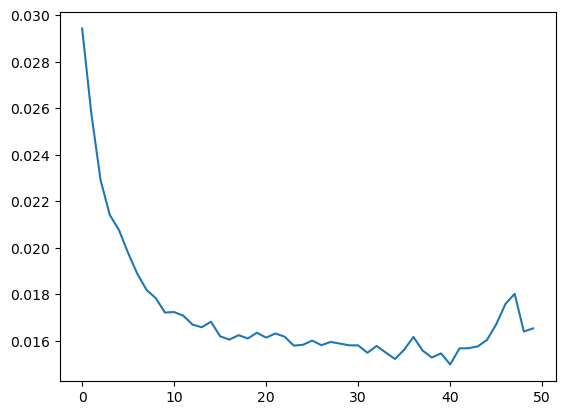

In [22]:
plt.plot(training_losses)

In [29]:
losses = []
batch_losses = []
targets = []
outputs = []
with torch.no_grad():
    for i, (data, target) in enumerate(pm_test_loader):
        out = net(data)
        loss = criterion(out, target)
#         print('Target : {:.4f}, Predicted Output : {:.4f}'.format(target.item(), out.item()))
        
        targets.append(target.item())
        outputs.append(out.item())
        
        batch_losses.append(loss.item())
    losses.append(np.mean(batch_losses))
print("Testing loss {:.6f}".format(losses[-1]))

Testing loss 0.146493


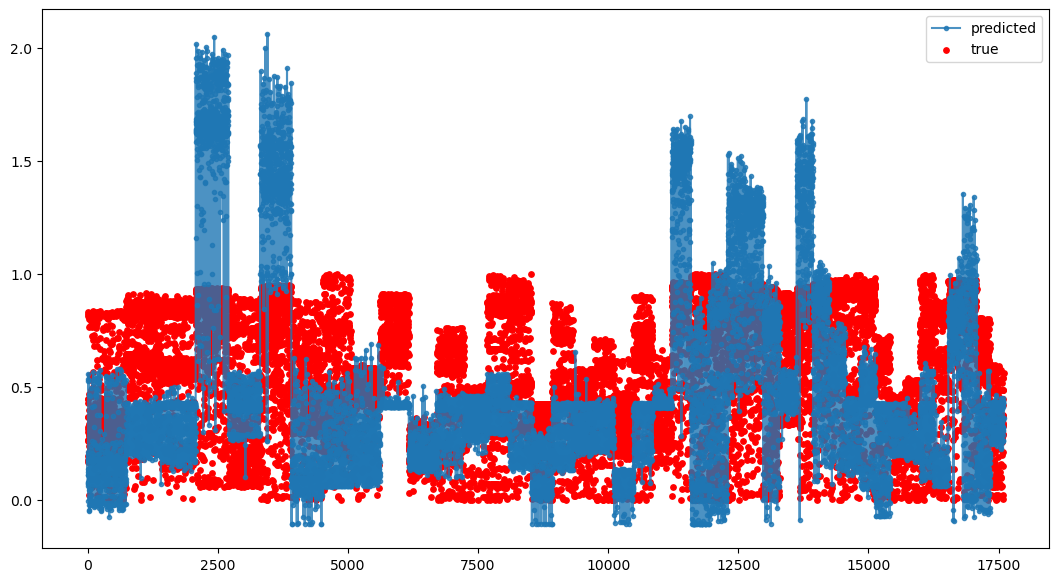

In [30]:
plt.figure(figsize=(13,7))
# plt.scatter(np.arange(len(outputs)),outputs, c = 'b', s = 15, marker='*', label = 'predicted')
plt.plot(np.arange(len(outputs)),outputs, alpha = 0.8, marker = '.',label = 'predicted' )
plt.scatter(np.arange(len(targets)),targets, c = 'r', s = 15, label = 'true')
plt.legend(loc='best')